In [1]:
using Symbolics, LinearAlgebra, Catalyst, JumpProcesses, Graphs, Plots
using OrdinaryDiffEq, StochasticDiffEq, JumpProcesses, LaTeXStrings
using Random: bitrand
using ValueHistories: MVHistory, @trace
using LaTeXStrings
using ModelingToolkit
using Distributions
using ForwardDiff

5.5 Learning CRN Parameters from Data (Example using Learning Rule)

First, we will setup our target distribution which comes from the 3-node straight Energy Based Model that we saw in 5.4.2 by taking N=3, biases = [0.5,0.3,0.8], weights = [0.4,0.2]. 
For later use, we will also set a small function that will compute the target value of datapoint from this target distribution.

In [2]:
#Test Data
#Taking 3-node straight BM as our target data again 
function N_node_straight_BM(N::Int64,biases,weights)
    num_states = 2^N
    states = [reverse(digits(i-1, base=2, pad=N)) for i in 1:num_states]
    Energies =[]
    for config in states
        Energy=0.0
        for i in 1:(N-1)
            Energy += weights[i] * config[i] * config[i+1]  # Interaction term
        end
        for i in 1:N
            Energy += biases[i] * config[i]  # Bias term
        end
        push!(Energies, Energy)
    end
    Z = sum(exp(-E) for E in Energies)
    # Probabilities Q for each configuration
    Q = [exp(-E) / Z for E in Energies]
    labels = [string(states[i]) for i in 1:length(states)]
    #display(bar(labels, Q, xlabel="States", ylabel=L"T(x)", legend=:topright, title="Target Distribution: Three Node EBM", label = L"T"))
    #We can also use above line to see the distribution in histogram
    return Q
end
function target_distribution(d::Int64,n::Int64,biases,weights)
    z = N_node_straight_BM(n,biases,weights)
    td = z[d+1]
    return td
end

target_distribution (generic function with 1 method)

5.5.1 Construction of CRN

From learning rule given by Equation (9), we will need one CRN but with two different settings to compute h(constructed) and v(constructed) from given config of v in order to compute gradient as described in 5.5.4

Here is our CRN of first setting, we denote it as CRN_pph, meaning CRN for positive phase in gradient. This CRN will be responsible for the positive phase component in our gradient computation. Here, we need to construct h from a given configuration of v (this v will come from datapoint itself). We initialize v from datapoint and first set h as some random configuration, we turn off all the reactions that could change the configuration of v so that after applying SSA, we will get a configuration of h, which will be our h_new. For just demonstration, I have shown it for n=3 and m=2. Generalising is done while writing the training of the model.

In [3]:
@variables t k₁₁ k₁₂ k₂₁ k₂₂ k₃₁ k₃₂ #time parameter and 6 parameters as rate constant, the number of kᵢⱼ will be nxm.
n = 3  # Number of pair of visible species
m=2    # Number of pair of hidden species
@parameters k₁₁ k₁₂ k₂₁ k₂₂ k₃₁ k₃₂ 
# Construct the 3x2 matrix
a_pph = [k₁₁ k₁₂;k₂₁ k₂₂;k₃₁ k₃₂] #Matrix containing forward rates of CRN_pph
b_pph = ones(Num, 3, 2) # backward rates are marked as 1
rxs=[]  #Generating empty list of Reactions
@species X⁰(t)[1:n] # Xᵢ⁰ specie 
@species X¹(t)[1:n] # Xᵢ¹ specie 
@species H⁰(t)[1:m] # Hᵢ⁰ specie 
@species H¹(t)[1:m] # Hᵢ¹ specie 
# We have turned off all the reactions of type Xᵢ⁰ <-> Xᵢ¹, as this will change the configuration of v
for i in 1:n
    push!(rxs, Reaction(0.0, [X⁰[i]], [X¹[i]], [1], [1]))
    push!(rxs, Reaction(0.0, [X¹[i]], [X⁰[i]], [1], [1]))
end
#We keep the reactions of type Hᵢ⁰ <-> Hᵢ¹ turned on in this CRN
for j in 1:m
    push!(rxs, Reaction(1.0, [H⁰[j]], [H¹[j]], [1], [1]))
    push!(rxs, Reaction(1.0, [H¹[j]], [H⁰[j]], [1], [1]))
end
#Again, we turn off all the reactions that change the configuration of Xᵢ and assign rates where configuration of Hⱼ could be changed
for i in 1:n
    for j in 1:m
        k = a_pph[i,j]
        push!(rxs, Reaction(k, [X¹[i], H⁰[j]], [X¹[i], H¹[j]], [1,1], [1,1]))
        push!(rxs, Reaction(1.0, [X¹[i], H¹[j]], [X¹[i], H⁰[j]], [1,1], [1,1]))
        push!(rxs, Reaction(0.0, [H¹[j], X⁰[i]], [H¹[j], X¹[i]], [1,1], [1,1]))
        push!(rxs, Reaction(0.0, [H¹[j], X¹[i]], [H¹[j], X⁰[i]], [1,1], [1,1]))
    end
end
@named crn_pph = ReactionSystem(rxs, t)
crn_pph = complete(crn_pph)

Model crn_pph
States (10):
  (X⁰(t))[1]
  (X¹(t))[1]
  (X⁰(t))[2]
  (X¹(t))[2]
⋮
Parameters (6):
  k₁₁
  k₁₂
  k₂₁
  k₂₂
⋮

Here is our CRN of second setting, we denote it as CRN_nph, meaning CRN for negative phase in gradient. This CRN will be responsible for the negative phase component in our gradient computation. Here, we need to construct new v from a given configuration of h_new (this h_new will come from SSA simulation of crn_pph). We initialize h as h_new and first set v as some random configuration, we turn off all the reactions that could change the configuration of h so that after applying SSA, we will get a configuration of v, which will be our v_new. For just demonstration, I have shown it for n=3 and m=2. Generalising is done while writing the training of the model.

In [4]:
@variables t bk₁₁ bk₁₂ bk₂₁ bk₂₂ bk₃₁ bk₃₂
n = 3  # Define the number of pair of visible species
m=2    #Define the number of pair of hidden species
@parameters bk₁₁ bk₁₂ bk₂₁ bk₂₂ bk₃₁ bk₃₂ 
# Construct the 3x2 matrix
a_nph = [bk₁₁ bk₁₂;bk₂₁ bk₂₂;bk₃₁ bk₃₂]
b_nph = ones(Num, 3, 2)
#@parameters t # Define time as a parameter
rxs=[]
# Create species using a loop
@species X⁰(t)[1:n] 
@species X¹(t)[1:n]
@species H⁰(t)[1:m]
@species H¹(t)[1:m]
for i in 1:n
    push!(rxs, Reaction(1.0, [X⁰[i]], [X¹[i]], [1], [1]))
    push!(rxs, Reaction(1.0, [X¹[i]], [X⁰[i]], [1], [1]))
end
for j in 1:m
    push!(rxs, Reaction(0.0, [H⁰[j]], [H¹[j]], [1], [1]))
    push!(rxs, Reaction(0.0, [H¹[j]], [H⁰[j]], [1], [1]))
end
for i in 1:n
    for j in 1:m
        k = a_nph[i,j]
        push!(rxs, Reaction(0.0, [X¹[i], H⁰[j]], [X¹[i], H¹[j]], [1,1], [1,1]))
        push!(rxs, Reaction(0.0, [X¹[i], H¹[j]], [X¹[i], H⁰[j]], [1,1], [1,1]))
        push!(rxs, Reaction(k, [H¹[j], X⁰[i]], [H¹[j], X¹[i]], [1,1], [1,1]))
        push!(rxs, Reaction(1.0, [H¹[j], X¹[i]], [H¹[j], X⁰[i]], [1,1], [1,1]))
    end
end
@named crn_nph = ReactionSystem(rxs, t)
crn_nph = complete(crn_nph)

Model crn_nph
States (10):
  (X⁰(t))[1]
  (X¹(t))[1]
  (X⁰(t))[2]
  (X¹(t))[2]
⋮
Parameters (6):
  bk₁₁
  bk₁₂
  bk₂₁
  bk₂₂
⋮

The output of previous two code lines is our CRN, first three reactions represent tendency of self-change (represents biases) of three visible nodes (X1¹,X1⁰), (X2¹,X2⁰) and (X3¹,X3⁰). In the same way, next two reactions represent biases of hidden nodes (H1¹,H1⁰) and (H2¹,H2⁰). Reactions with kᵢⱼ as rate constants represent interaction of Xi¹ or Xi⁰ with Hj¹ or Hj⁰. The order of the species will remain same throughout the code.

Now, we convert our crn_pph and crn_nph (that are Reaction Networks from Modeling Toolkit) into a JumpSystem object. A JumpSystem is the low‑level representation of a discrete‐event (jump) system that the SSA solver can simulate.
We set combinatoric_ratelaws=true so that the converter can apply combinatorial mass‐action rate laws. In practice this means the propensities will be computed with the correct combinatorial factor​. This ensures our stochastic kinetics match the intended chemistry.
Next we pull out the list of all the species “symbols” that appear in our crn_pph. These become the state variables of the system, in the same order the JumpSystem will use internally.
And, then we put these specie in particular set for the ease of computation.
The following code also does the generalisation part for our crn that we talked just before. The next two lines contains a function that only takes n and m as input and write a crn of each setting and also converts them into jump system so that we can apply ssa.

In [5]:

"""
A JumpSystem and species lists is generated for our CRN with positive phase setting with n visible and m hidden species.
Rates kᵢⱼ are generated as parameters a_pphᵢⱼ
"""
function jumpsys_crnpph(n::Int, m::Int)
    @variables t
    @parameters a_pph[1:n, 1:m] #Rate constants, (our first set of parameters)
    @species X⁰(t)[1:n] X¹(t)[1:n] H⁰(t)[1:m] H¹(t)[1:m]
    rxs = Reaction[]
    for i in 1:n
        push!(rxs, Reaction(0.0,  [X⁰[i]], [X¹[i]], [1], [1]))
        push!(rxs, Reaction(0.0,  [X¹[i]], [X⁰[i]], [1], [1]))
    end
    for j in 1:m
        push!(rxs, Reaction(1.0,  [H⁰[j]], [H¹[j]], [1], [1]))
        push!(rxs, Reaction(1.0,  [H¹[j]], [H⁰[j]], [1], [1]))
    end
    # coupling flips (X stays same, H flips via a_pph and back)
    for i in 1:n
        for j in 1:m
            kf = a_pph[i,j]
            push!(rxs, Reaction(kf,      [X¹[i], H⁰[j]], [X¹[i], H¹[j]], [1,1], [1,1]))
            push!(rxs, Reaction(1.0,     [X¹[i], H¹[j]], [X¹[i], H⁰[j]], [1,1], [1,1]))
            # disabled:
            push!(rxs, Reaction(0.0,     [H¹[j], X⁰[i]], [H¹[j], X¹[i]], [1,1], [1,1]))
            push!(rxs, Reaction(0.0,     [H¹[j], X¹[i]], [H¹[j], X⁰[i]], [1,1], [1,1]))
        end
    end
    # build ReactionSystem
    @named rsys = ReactionSystem(rxs, t)
    crn_pph = complete(rsys)
    # convert to JumpSystem and extract states
    jumpsys_pph = convert(JumpSystem, crn_pph; combinatoric_ratelaws=true)
    species_pph = states(crn_pph)
    # filter species by name
    X⁰species_pph = filter(s -> string(s) |> contains("X⁰"), species_pph)
    X¹species_pph = filter(s -> string(s) |> contains("X¹"), species_pph)
    H⁰species_pph = filter(s -> string(s) |> contains("H⁰"), species_pph)
    H¹species_pph = filter(s -> string(s) |> contains("H¹"), species_pph)
    a_pph = a_pph
    return crn_pph, a_pph, jumpsys_pph, X⁰species_pph, X¹species_pph, H⁰species_pph, H¹species_pph 
end

jumpsys_crnpph

In [6]:
"""
A JumpSystem and species lists is generated for our CRN with negative phase setting with n visible and m hidden species.
Rates kᵢⱼ are generated as parameters a_nphᵢⱼ
"""
function jumpsys_crnnph(n::Int, m::Int)
    # time variable
    @variables t
    @parameters a_nph[1:n, 1:m]
    @species X⁰(t)[1:n] X¹(t)[1:n] H⁰(t)[1:m] H¹(t)[1:m]
    # collect reactions
    rxs = Reaction[]
    # turn off X flips (rate=0)
    for i in 1:n
        push!(rxs, Reaction(1.0,  [X⁰[i]], [X¹[i]], [1], [1]))
        push!(rxs, Reaction(1.0,  [X¹[i]], [X⁰[i]], [1], [1]))
    end
    # H flips on (rate=1)
    for j in 1:m
        push!(rxs, Reaction(0.0,  [H⁰[j]], [H¹[j]], [1], [1]))
        push!(rxs, Reaction(0.0,  [H¹[j]], [H⁰[j]], [1], [1]))
    end
    # coupling flips (X stays same, H flips via a_pph and back)
    for i in 1:n
        for j in 1:m
            kf = a_nph[i,j]
            push!(rxs, Reaction(0.0,      [X¹[i], H⁰[j]], [X¹[i], H¹[j]], [1,1], [1,1]))
            push!(rxs, Reaction(0.0,     [X¹[i], H¹[j]], [X¹[i], H⁰[j]], [1,1], [1,1]))
            # disabled:
            push!(rxs, Reaction(kf,     [H¹[j], X⁰[i]], [H¹[j], X¹[i]], [1,1], [1,1]))
            push!(rxs, Reaction(1.0,     [H¹[j], X¹[i]], [H¹[j], X⁰[i]], [1,1], [1,1]))
        end
    end
    # build ReactionSystem
    @named rsys = ReactionSystem(rxs, t)
    crn_nph = complete(rsys)
    # convert to JumpSystem and extract states
    jumpsys_nph = convert(JumpSystem, crn_nph; combinatoric_ratelaws=true)
    species_nph = states(crn_pph)
    # filter species by name
    X⁰species_nph = filter(s -> string(s) |> contains("X⁰"), species_nph)
    X¹species_nph = filter(s -> string(s) |> contains("X¹"), species_nph)
    H⁰species_nph = filter(s -> string(s) |> contains("H⁰"), species_nph)
    H¹species_nph = filter(s -> string(s) |> contains("H¹"), species_nph)
    a_nph = a_nph
    return crn_nph, a_nph, jumpsys_nph, X⁰species_nph, X¹species_nph, H⁰species_nph, H¹species_nph 
end

jumpsys_crnnph

5.5.2 Stationary Distribution and Marginalization

Now we define the stationary distribution using Markov Chain Tree Theorem, From 5.5.2, we understand that we have to compute Qˢˢ: We will do it in mctt way :)
In our CRN, there 2 set of species, visible and hidden, so we can consider a bipartite graph that has vertices as visible and hidden pair of species. We take bipartite graph of (n,m); as written n is the number of pairs of visible and m is the number of pairs of hidden species. We assign the edges as rate of reaction. Suppose Vertices are V union H, each vertex i of V is connected to every j vertex of H and that edge will denote two reversible reactions:
Xi¹+Hj⁰ <-> Xi¹+Hj¹ with forward rate a_pph[i,j] and backward rate 1
and
Hi¹+Xj⁰ <-> Hi¹+Xj¹ with forward rate a_nph[i,j] and backward rate 1
After defining graph, we now write a program that will assign reaction rate constants to vertex tuple.

In [7]:
# 1. Create bipartite graph between X-nodes (1–n) and H-nodes (n+1-n+m)
function bipartite_graph_visible_hidden(n::Int, m::Int)
    total = n + m
    g = SimpleGraph(total)
    for i in 1:n, j in (n+1):(n+m)
        add_edge!(g, i, j)
    end
    return g
end
# 2. Assign forward/backward rates from parameter matrices a_pph and b_nph
function rates_crn_rule(a_pph::Matrix{T}, a_nph::Matrix{T}, n::Int64, m::Int64) where T <: Real
    g = bipartite_graph_visible_hidden(n, m)
    rates_fwd = Dict{Tuple{Int,Int}, T}()
    rates_bwd = Dict{Tuple{Int,Int}, T}()
    for e in edges(g)
        iX, jH = src(e), dst(e)
        # enforce iX in 1:4, jH in 5:6
        if jH < iX
            iX, jH = jH, iX
        end
        xi = iX                # 1–4
        hj = jH - n            # 1–2
        # Forward rate for Xi^1 + Hj^0 -> Xi^1 + Hj^1
        rates_fwd[(iX, jH)] = a_pph[xi, hj]
        rates_bwd[(iX, jH)] = one(T)
        # Forward rate for Hj^1 + Xi^0 -> Hj^1 + Xi^1
        rates_fwd[(jH, iX)] = a_nph[xi, hj]
        rates_bwd[(jH, iX)] = one(T)
    end
    return rates_fwd, rates_bwd
end

rates_crn_rule (generic function with 1 method)

We write a function that will generate the Q for our crn.

In [8]:
#Defining Matrix Q using MCTT
function Q_rule(a_pph::Matrix{T}, a_nph::Matrix{T},n,m) where T <: Real
    N = n+m
    S = 2^N
    configs = [reverse(digits(i-1, base=2, pad=N)) for i in 1:S]
    rates_fwd, rates_bwd = rates_crn_rule(a_pph, a_nph,n,m)
    P = zeros(T, S, S)
    # (a) Single flips Xi and Hj at rate 1
    for i in 1:S
        state = configs[i]
        for v in 1:N
            new = copy(state)
            new[v] = 1 - new[v]
            j = 1 + foldl((acc,b)->acc*2 + b, new, init=0)
            P[i,j] += one(T)
            P[i,i] -= one(T)
        end
    end
    # (b) Coupled flips along bipartite edges
    g = bipartite_graph_visible_hidden(n, m)
    for i in 1:S
        state = configs[i]
        for e in edges(g)
            iX, jH = src(e), dst(e)
            if jH < iX
                iX, jH = jH, iX
            end
            # if u=Xi and v=Hj
            # forward X→H
            if state[iX]==1 && state[jH]==0
                new = copy(state); new[jH]=1
                j = 1 + foldl((acc,b)->acc*2 + b, new, init=0)
                r = get(rates_fwd,(iX,jH), zero(T))
                P[i,j] += r; P[i,i] -= r
            # backward H→0 on Xi^1+Hj^1→Xi^1+Hj^0
            elseif state[iX]==1 && state[jH]==1
                new = copy(state); new[jH]=0
                j = 1 + foldl((acc,b)->acc*2 + b, new, init=0)
                r = get(rates_bwd,(iX,jH), zero(T))
                P[i,j] += r; P[i,i] -= r
            end
            # now if u=Hj and v=Xi
            # forward H→X
            if state[jH]==1 && state[iX]==0
                new = copy(state); new[iX]=1
                j = 1 + foldl((acc,b)->acc*2 + b, new, init=0)
                r = get(rates_fwd,(jH,iX), zero(T))
                P[i,j] += r; P[i,i] -= r
            # backward X→0 on Hj^1+Xi^1→Hj^1+Xi^0
            elseif state[jH]==1 && state[iX]==1
                new = copy(state); new[iX]=0
                j = 1 + foldl((acc,b)->acc*2 + b, new, init=0)
                r = get(rates_bwd,(jH,iX), zero(T))
                P[i,j] += r; P[i,i] -= r
            end
        end
    end
    return P
end


Q_rule (generic function with 1 method)

5.5.3 Defining Loss-function

We now define our loss function described in 5.5.3. We first compute model distribution \pi_omega using the definition given in 5.5.2 and then define the KL-divergence between target and model distribution.
Model distribution is the distribution generated by our CRN.

In [9]:
function Q_objective(params::AbstractVector{T}, n::Int, m::Int) where T<:Real
    a_pph = reshape(params[1:n*m], n, m)
    a_nph = reshape(params[n*m+1:2*n*m], n, m)
    Q = Q_rule(a_pph,a_nph,n,m)
    N = n+m
    S = 2^N
    z = Vector{T}(undef, S)
    for i in 1:S
        rows = collect(1:S) .!= i
        cols = collect(1:S) .!= i
        minor = Q[rows, cols]
        z[i] = det(minor)
    end
    s = sum(z)
    return z ./ s
end
function loss_function(param::AbstractVector{T},n::Int, m::Int, biases, weights) where T<:Real
    Q = Q_objective(param,n,m)
    config1 = [reverse(digits(i-1, base=2, pad=n)) for i in 1:2^n]
    Pi_Omega = zeros(Float64, 2^n)
    for i in 1:2^n
        v = config1[i]
        config2 = [reverse(digits(j-1,base=2,pad=m)) for j in 1:2^m]
        sumv = 0.0
        for h in config2
            s1 = vcat(v,h)
            binary_string1 = join(string.(s1))
            d1 = parse(Int, binary_string1, base=2)+1
            sumv += Q[d1]
        end
        Pi_Omega[i] = sumv
    end
    true_data = N_node_straight_BM(n,biases,weights)
    model_data = Pi_Omega
    kl_div = zero(T)
    for i in eachindex(model_data)
        piT = T(true_data[i])
        piM = max(model_data[i], T(1e-8))
        kl_div += piT * log(piT/piM)
    end
    return kl_div
end

loss_function (generic function with 1 method)

5.5.4 Computing Gradient

From learning rule in Equation (9), it is clear that we need to compute Qᵛʰ and Qʷʰ in order to compute gradients. 
For the computation of Qᵛʰ, we take v as our datapoint, then generate h=h_new using SSA and then we concatenate v,h into a single vector. We then enumerate this single vector based on their decimal representation and compute the Qᵛʰ using given two functions.
For computing Qʷʰ, we follow the same procedure by taking w=v_new and h=h_new. 
For these two computations, we will write the required function that take their indexes as argument.

In [10]:
#Defining Qˢˢ
function adjoint_Q(d::Int64, params::AbstractVector{T},n::Int64,m::Int64) where T<:Real
    # d will be the decimal representation of state combined by v and h
    a_pph = reshape(params[1:n*m], n, m)
    a_nph = reshape(params[n*m+1:2*n*m], n, m)
    Q = Q_rule(a_pph,a_nph,n,m)
    N = n+m
    S = 2^N
    minor = Q[[1:d-1; d+1:S], [1:d-1; d+1:S]]
    return minor
end

adjoint_Q (generic function with 1 method)

Since we also need to compute the derivative of Qˢˢ, we will now make this matrix into a 1 dimensional vector so that we can apply ForwardDiff and easily compute the derivative without using Symbolics.
I have tested and verified that using Symbolics instead of ForwardDiff costs 50x time, while using the same hardware.

In [32]:
#Flattening Qˢˢ to use ForwardDiff
function adjoint_Q_flatten(params::AbstractVector{T},d::Int, n::Int, m::Int) where T<:Real
    a_pph = reshape(params[1:n*m], n, m)
    a_nph = reshape(params[n*m+1:2*n*m], n, m)
    P = adjoint_Q(d,params,n,m)
    return vec(P)                     
end

adjoint_Q_flatten (generic function with 1 method)

Now, we define our training model that takes input as v (visible configuration), n and m, initialized parameter set and arguments of target distribution.
Since, we have taken target distribution as Energy Based Model with n straight nodes connected and have parameters as n, biases and weights, so we have taken biases and weights as our parameter in training model.

In [12]:
function crn_training(v::Vector{Int},n::Int64,m::Int64,biases,weights,param::AbstractVector{T}) where T<:Real
    tdv = target_distribution(parse(Int, join(string.(v)), base=2),n,biases,weights) #gives T(v) of datapoint
    N=n+m
    S=2^N
    
    #Positive Phase Computation of Gradient:
    initial_value_X¹_pph = v  # Initial values for X¹ species which is v (datapoint)
    initial_value_H¹_pph = [1 for j in 1:m]  # Randomly initialize values for H¹ species
    initial_value_X⁰_pph = [1 - initial_value_X¹_pph[i] for i in 1:n] #Initial values for X⁰ species
    initial_value_H⁰_pph = [1 - initial_value_H¹_pph[j] for j in 1:m] #Initial values for H⁰ species
    # Now we map the initial concentration of species to the species of crn_pph
    XN = [X¹species_pph[i] => initial_value_X¹_pph[i] for i in 1:n]
    XO = [X⁰species_pph[i] => initial_value_X⁰_pph[i] for i in 1:n]
    HN = [H¹species_pph[j] => initial_value_H¹_pph[j] for j in 1:m]
    HO = [H⁰species_pph[j] => initial_value_H⁰_pph[j] for j in 1:m]
    # Concatenate all initial values into a single vector
    u0map_pph = vcat(XN, HN, XO, HO)
    param_pph = param[1:n*m] #taking first half of parameters that will be rateconstants for crn_pph
    tspan = (0.0,100.0)
    pm_pph = [ a_pph[i,j] => param_pph[(i-1)*m + j] for i in 1:n for j in 1:m ] #assigning initial parameters to rateconstants of crn_pph
    pm_pph = vec(pm_pph) 
    dprob_pph = DiscreteProblem(jumpsys_pph, u0map_pph, tspan, pm_pph)
    jprob_pph = JumpProblem(jumpsys_pph, dprob_pph, Direct())
    sol = solve(jprob_pph, SSAStepper())
    e = sol[end]  #SSA generates the new configuration of crn_pph 
    h_new = [ e[2*n + 2*j] for j in 1:m ] #taking out configuration of H¹ species
    s1=vcat(v,h_new) #Concatenating v and h_new into vh_new
    binary_string1 = join(string.(s1))
    d1 = parse(Int, binary_string1, base=2)+1 #Determining the index of state vh_new from all (n+m) length binary vector
    Q1= adjoint_Q(d1, param,n,m) #Computing Qᵛʰ
    J1 = ForwardDiff.jacobian(p -> adjoint_Q_flatten(p, d1, n, m), param) #Computing ∂Qᵛʰ/∂param
    # Extracting the derivative‑matrices
    dP_d01 = Matrix{typeof(param[1])}[]
    for k in 1:2*n*m #derivative of Qᵛʰ with respect to every 2*n*m parameter
        col = J1[:, k]                    
        push!(dP_d01, reshape(col, S-1, S-1)) 
    end
    Q1=inv(Q1)
    trace1 = map(M -> tr(Q1 * M), dP_d01) #See Equation 9 
    pph = tdv .* trace1 #Positive Phase component computed


    #Negative Phase Computation of Gradient:
    initial_value_X¹_nph = v  # not mandatory to use datapoint, any v will work
    initial_value_H¹_nph = h_new  # Initialized by newly constructed h only
    initial_value_X⁰_nph = [1 - initial_value_X¹_nph[i] for i in 1:n]
    initial_value_H⁰_nph = [1 - initial_value_H¹_nph[j] for j in 1:m]
    # Mapping the initial concentration of species to the species of crn_nph
    XN_n = [X¹species_nph[i] => initial_value_X¹_nph[i] for i in 1:n]
    XO_n = [X⁰species_nph[i] => initial_value_X⁰_nph[i] for i in 1:n]
    HN_n = [H¹species_nph[j] => initial_value_H¹_nph[j] for j in 1:m]
    HO_n = [H⁰species_nph[j] => initial_value_H⁰_nph[j] for j in 1:m]
    # Concatenate all initial values into a single vector
    u0map_nph = vcat(XN_n, HN_n, XO_n, HO_n)
    param_nph = param[n*m+1:2*n*m] #taking second half of parameters that will be rateconstants for crn_nph
    tspan = (0.0,100.0)
    pm_nph = [ a_nph[i,j] => param_nph[(i-1)*m + j] for i in 1:n for j in 1:m ] #assigning initial parameters to rateconstants of crn_nph
    pm_nph = vec(pm_nph)
    dprob_nph = DiscreteProblem(jumpsys_nph, u0map_nph, tspan, pm_nph) 
    jprob_nph = JumpProblem(jumpsys_nph, dprob_nph, Direct())
    sol_nph = solve(jprob_nph, SSAStepper())
    e_nph = sol_nph[end] #SSA generates the new configuration of crn_nph 
    v_new = [e_nph[2*i] for i in 1:n] #taking out configuration of X¹ species
    s2=vcat(v_new,h_new) #Concatenating v_new and h_new into v_new h_new, this will be our w h (See 5.5.5)
    binary_string2 = join(string.(s2))
    d2 = parse(Int, binary_string2, base=2)+1 #Determining the index of state v_new h_new from all (n+m) length binary vector
    Q2= adjoint_Q(d2, param,n,m) #Computing Qʷʰ
    J2 = ForwardDiff.jacobian(p-> adjoint_Q_flatten(p,d2,n,m), param) #Computing ∂Qʷʰ/∂param
    # Extracting the derivative‑matrices
    dP_d02 = Matrix{typeof(param[1])}[]
    for k in 1:2*n*m #derivative of Qʷʰ with respect to every 2*n*m parameter
        col = J2[:,k]
        push!(dP_d02, reshape(col,S-1,S-1))
    end
    Q2=inv(Q2)
    trace2 = map(M -> tr(Q2 * M), dP_d02) #See Equation 9
    nph = trace2 #Negative Phase component computed

    return nph, pph
end

crn_training (generic function with 1 method)

Verification of our Learning Rule

In [13]:
#Setting Test Data and CRN model
n=3
m=2
biases = [0.5,0.3,0.8] 
weights = [0.4,0.2]
crn_pph, a_pph, jumpsys_pph, X⁰species_pph, X¹species_pph, H⁰species_pph, H¹species_pph = jumpsys_crnpph(n,m)
crn_nph, a_nph, jumpsys_nph, X⁰species_nph, X¹species_nph, H⁰species_nph, H¹species_nph = jumpsys_crnnph(n,m)

(ReactionSystem{Catalyst.NetworkProperties{Int64, SymbolicUtils.BasicSymbolic{Real}}}(Union{Equation, Reaction}[1.0, (X⁰(t))[1] --> (X¹(t))[1], 1.0, (X¹(t))[1] --> (X⁰(t))[1], 1.0, (X⁰(t))[2] --> (X¹(t))[2], 1.0, (X¹(t))[2] --> (X⁰(t))[2], 1.0, (X⁰(t))[3] --> (X¹(t))[3], 1.0, (X¹(t))[3] --> (X⁰(t))[3], 0.0, (H⁰(t))[1] --> (H¹(t))[1], 0.0, (H¹(t))[1] --> (H⁰(t))[1], 0.0, (H⁰(t))[2] --> (H¹(t))[2], 0.0, (H¹(t))[2] --> (H⁰(t))[2]  …  a_nph[2, 2], (H¹(t))[2] + (X⁰(t))[2] --> (H¹(t))[2] + (X¹(t))[2], 1.0, (H¹(t))[2] + (X¹(t))[2] --> (H¹(t))[2] + (X⁰(t))[2], 0.0, (X¹(t))[3] + (H⁰(t))[1] --> (X¹(t))[3] + (H¹(t))[1], 0.0, (X¹(t))[3] + (H¹(t))[1] --> (X¹(t))[3] + (H⁰(t))[1], a_nph[3, 1], (H¹(t))[1] + (X⁰(t))[3] --> (H¹(t))[1] + (X¹(t))[3], 1.0, (H¹(t))[1] + (X¹(t))[3] --> (H¹(t))[1] + (X⁰(t))[3], 0.0, (X¹(t))[3] + (H⁰(t))[2] --> (X¹(t))[3] + (H¹(t))[2], 0.0, (X¹(t))[3] + (H¹(t))[2] --> (X¹(t))[3] + (H⁰(t))[2], a_nph[3, 2], (H¹(t))[2] + (X⁰(t))[3] --> (H¹(t))[2] + (X¹(t))[3], 1.0, (H¹(t))[2] + (

We have to pay attention while selecting our learning rate as I haven't put much focus in determining the efficient learning rate. As we go closer to the minimum, the local curvature of the loss surface may get changed. So sometimes, step size may become too large relative to the tiny gradients near the bottom, so we have to avoid overshooting the optimum on every update. Those overshoots may accumulate and the KL would slowly start creeping back up.
We can use several methods to overcome, I want simplicity for now so I would go for either inverse-time decay or exponential decay schedule. 
I would love to hear more ways from the viewers.

In [14]:
divergences=[]
Optimizers=[]
configs = [reverse(digits(i-1, base=2, pad=n)) for i in 1:2^n]
tolerance = 1e-5
param = [1.0 for i in 1:2*n*m]
#Inverse-time decay schedule
lr0   = Float64(0.05)       # your original 0.05
decay = 0.005       # you can tune this: smaller means slower decay
for iter in 1:4000
    lr = lr0 / (1 + decay*(iter-1))
    pph = zeros(eltype(param), 2*n*m)
    nph = zeros(eltype(param), 2*n*m)
    for v in configs
        nph1, pph1 = crn_training(v,n,m,biases,weights,param)
        nph = nph1
        pph .+= pph1
    end
    grad = nph .- pph
    new_param = param .- lr .* grad
    if norm(new_param-param)<tolerance
        println(t)
        break
    end
    param = new_param
    param = [max(x, 0.0) for x in param]
    push!(divergences, loss_function(param,n,m,biases,weights))
    push!(Optimizers, param)
end

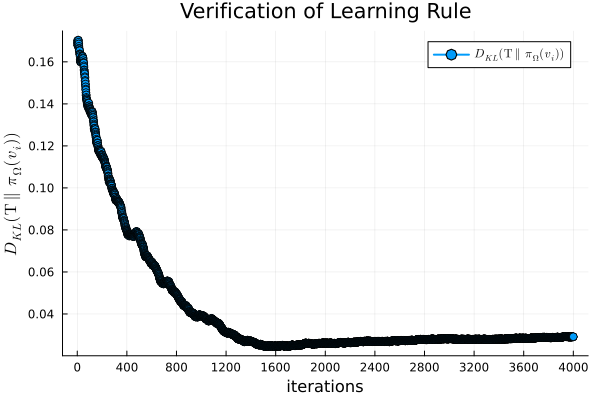

In [15]:
#Plotting the KL divergence vs iterations 
iteration = 1:4000
plot(iteration, divergences, xticks=0:400:4000, marker=:o, xlabel="iterations", ylabel=L"D_{KL}(\mathrm{T}\parallel \pi_{\Omega}(v_{i}))", title="Verification of Learning Rule", label=L"D_{KL}(\mathrm{T} \parallel \pi_{\Omega}(v_{i}))", lw=2, legend=:topright)

In the end we write a function that takes set of parameters of CRN as argument and generate probability distributions. This will be an illustration of "CRN being capable of generating probability distributions".

In [16]:
function crn_distribution(param::AbstractVector{T},n::Int, m::Int) where T<:Real
    Q = Q_objective(param,n,m)
    config1 = [reverse(digits(i-1, base=2, pad=n)) for i in 1:2^n]
    Pi_Omega = zeros(Float64, 2^n)
    for i in 1:2^n
        v = config1[i]
        config2 = [reverse(digits(j-1,base=2,pad=m)) for j in 1:2^m]
        sumv = 0.0
        for h in config2
            s1 = vcat(v,h)
            binary_string1 = join(string.(s1))
            d1 = parse(Int, binary_string1, base=2)+1
            sumv += Q[d1]
        end
        Pi_Omega[i] = sumv
    end
    z = Pi_Omega
    s = sum(z)
    Q = [ zi/s for zi in z]
    labels = [string(config1[i]) for i in 1:length(config1)]
    #display(bar(labels, Q, xlabel="States", ylabel=L"π\_{Ω}(x)", legend=:topright, title="Probability Distribution generated by CRN", label = L"π\_{Ω}"))
    #We can also use above line to see the distribution in histogram
    return Q
end

crn_distribution (generic function with 1 method)

We now see if distribution generated by crn could approximate our target distribution or not. This will act as a proof that CRN could generate distributions and hence can be used for learning different distribution.

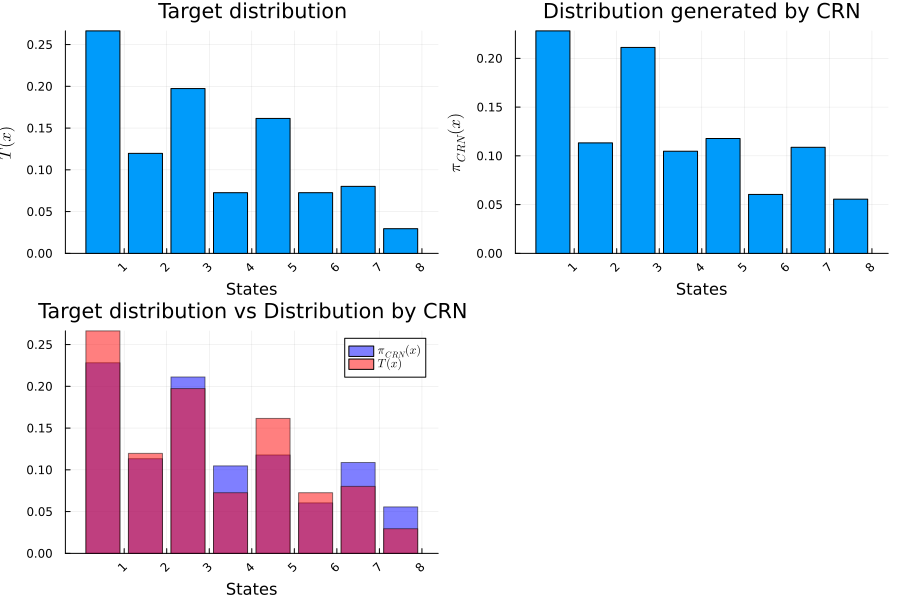

ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error


In [17]:
configurations = [reverse(digits(i-1, base=2, pad=n)) for i in 1:2^n]
labels = [string(configurations[i]) for i in 1:length(configurations)]
true_data = N_node_straight_BM(n,biases,weights)
model_data= crn_distribution(Optimizers[end],n,m) #Last set of parameter would be more Optimal
p1 = bar(labels, true_data, xlabel="States", ylabel=L"T(x)", title="Target distribution", xticks=collect(1:length(labels)), xrotation=45, legend=false)
p2 = bar(labels, model_data, xlabel="States", ylabel=L"π_{CRN}(x)", title="Distribution generated by CRN", xticks=collect(1:length(labels)), xrotation=45,legend=false)
p3 = bar(labels, model_data,xlabel="States", ylabel=L"T(x) \hspace{2mm} or \hspace{2mm} π_{CRN}(x)", title="Target distribution vs Distribution by CRN", xticks=collect(1:length(labels)), xrotation=45,label=L"π_{CRN}(x)", color=:blue, alpha=0.5)
bar!(labels, true_data, label=L"T(x)", color=:red, alpha=0.5)
l = @layout [a b; c c]
plot(p1, p2, p3, layout=l, size=(900,600))
